#  Storm Benchmarks
Initial Statistics
------

This test was performed with the storm AdvertisingTopology reading from 5 kafka instances. 
The kafka instances were collectively fed json-serialized events at various throughputs:

 - 50000/s
 - 60000/s
 - 70000/s
 - 100000/s
 - 110000/s
 - 120000/s
 - 130000/s
 - 135000/s

### Graphs
Counts were calculated by the topology in 10-second windows, and updated counts were written to the redis database once per second.

Because we send updates to redis once per second, we expect most of the end-to-end latency measurments between kafka and redis to be less than 1000ms.

#### Histogram
The first graph is a normalized histogram of the amount of time in ms it took for a window to get its final update after the window officially ended. That is, once events stop being emitted for a window, this is how long it took for the final counts to be written. As expected, because of the 1s publishing period, the graph has a sharp dropoff at 1000ms - except for the 135000/s throughput in cyan. This is where the topology began to get behind on processing stuff from kafka, and indicates the upper bound of throughput that this topology will handle.

#### Percentiles
The rest of the graphs compare the percentiles of end-to-end latency (end-to-end being kafka producer to redis database) They don't measure on the granularity of tuples, but instead measure how long it takes for a window to converge on its final value after the window has ended. In other words, they measure the length of time between the final tuple for a given window being produced, and that tuple's data being written into redis. 

The first pair is end-to-end after the window close, and the second pair is end-to-end after the expected 1000ms latency.


In [2]:

from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



In [3]:
%matplotlib inline

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy.stats import norm

In [5]:
def get_filtered_updated(filename, window_size_ms):
    update_times = np.loadtxt(filename, dtype=int)
    filtered_times = [x - window_size_ms for x in update_times if x >= window_size_ms]
    return filtered_times

In [32]:
window_size_ms = 10000   #10 seconds (for me). Adjust to match your benchmark and common component.

files = [("./first_run/FLINK/170000/updated.txt", "green", "50000")]
         #("./first_run/storm/70000/updated.txt", "red", "70000"),
         #("./first_run/storm/90000/updated.txt", "blue", "90000"),
         #("./first_run/storm/110000/updated.txt", "yellow", "110000"),
         #("./first_run/storm/130000/updated.txt", "purple", "130000"),
         #("./first_run/storm/150000/updated.txt", "orange", "150000"),
         #("./first_run/storm/170000/updated.txt", "black", "170000")]

filtered = [(get_filtered_updated(filename, window_size_ms), color, label) for (filename, color, label) in files]
print(filtered)

#bins = np.linspace(0, 10000, 100)

#plt.figure(num=None, figsize=(15, 10))
#map(lambda((filter_each, color, label)): plt.hist(filter_each, bins, normed=1, facecolor=color, alpha=0.5, label=label+"/s"), filtered)
#plt.xlabel('Last update time (in ms after window ended)')
#plt.ylabel('Window Count')
#plt.title('Histogram of Last Window Update Times (Estimated end-to-end latency)')
#plt.legend(loc="upper right")
#plt.show()

[([726, 723, 719, 715, 712, 708, 702, 699, 696, 692, 689, 685, 681, 678, 674, 671, 668, 664, 660, 657, 653, 635, 632, 628, 624, 621, 617, 613, 610, 606, 602, 597, 593, 589, 586, 581, 575, 571, 531, 527, 524, 520, 517, 513, 509, 505, 502, 1498, 492, 488, 485, 474, 470, 466, 463, 459, 455, 1452, 1439, 434, 1431, 1427, 423, 420, 409, 406, 402, 398, 1394, 1391, 1387, 382, 1379, 374, 371, 366, 363, 359, 356, 1353, 1349, 1345, 1341, 1338, 1334, 1330, 1326, 1323, 1319, 1315, 1257, 1253, 1249, 1245, 1241, 1237, 1234, 1230, 225, 1222, 1218, 1215, 1201, 1197, 1193, 1189, 1177, 1174, 1170, 1166, 1162, 1158, 1154, 1105, 1101, 1098, 1094, 1090, 1084, 1080, 1076, 1063, 1059, 1055, 1051, 1047, 1043, 1039, 1036, 1032, 1028, 1024, 1020, 1017, 1013, 1009, 1005, 1002, 998, 995, 991, 987, 982, 978, 973, 968, 964, 960, 957, 953, 949, 946, 942, 938, 923, 920, 915, 911, 908, 903, 899, 896, 893, 889, 885, 881, 878, 874, 871, 867, 863, 859, 855, 851, 848, 844, 840, 1837, 832, 829, 825, 821, 817, 811, 421, 413,

## Percentiles

Percentiles for the last-update time. 90th percentile being within 1000ms or so indicates that the topology is keeping up with the throughput.

We can see that at ~135000 tuples/s input, the topology begins to fall behind, and end-to-end latency goes up.

In [29]:
#Draws percentile charts from tuples of ([points], [percentiles], label)
def draw_line(tuple):
    print(tuple[1])
#def draw_line(points, percentiles, label):    
    #plt.plot(np.linspace(0,100, len(points)), points, label=(label + "/s"))
    #plt.plot(p, percentiles, 'ro')

# Percentile values
p = np.array([1.0, 10.0, 25.0, 50.0, 75.0, 90.0, 99.0, 100])

sorted = [(np.sort(filter), np.percentile(np.sort(filter), p), label) for (filter, _, label) in filtered]

print(sorted)
# Do the drawing
#plt.figure(num=None, figsize=(15, 10))
map(lambda x: print(x), sorted)

#plt.legend(loc="upper left")
#plt.xlabel('Percent of Tuples Complete')
#plt.ylabel('Time (ms) After Window Closed')
#plt.title('Percentile Comparison of Last Window Update Times')
#plt.show()

#print("Percentiles: ", p)

[(array([   0,    0,    0, ..., 1376, 1376, 1376]), array([  23.,  139.,  317.,  585.,  837.,  975., 1244., 1376.]), '50000')]


### *Late* Publishes
Here are the percentiles for the windows that were published *after* the expected 1000ms cutoff:

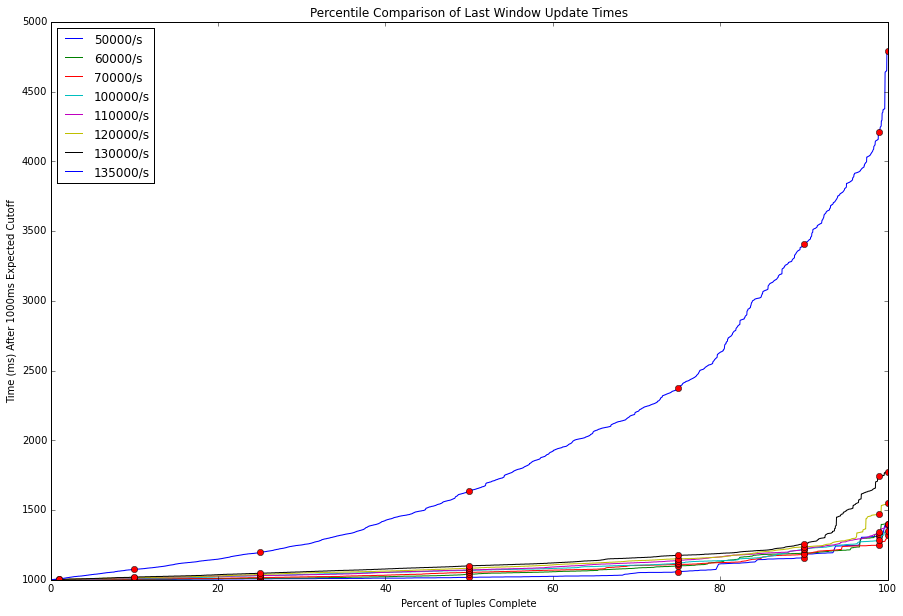

In [84]:
# Percentile values
p = np.array([1.0, 10.0, 25.0, 50.0, 75.0, 90.0, 99.0, 100])

def filter_and_sort((sorted_each, _, label)):
    filtered_sorted = [x for x in sorted_each if x > 1000]
    perc = mlab.prctile(filtered_sorted, p=p)
    return (filtered_sorted, perc, label)

# Filter all data points <= 1000 ms
filtered_sorted = map(filter_and_sort, sorted)

# Do the actual drawing
plt.figure(num=None, figsize=(15, 10))
map(draw_line, filtered_sorted)

plt.legend(loc="upper left")
plt.xlabel('Percent of Tuples Complete')
plt.ylabel('Time (ms) After 1000ms Expected Cutoff')
plt.title('Percentile Comparison of Last Window Update Times')
plt.show()